In [1]:
%pip install river

  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1:
      Successfully uninstalled numpy-1.23.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
gensim 4.2.0 requires Cython==0.29.28, but you have cython 0.29.30 which is incompatible.


In [97]:
from kafka import KafkaConsumer
import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import classification_report,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from river.drift import KSWIN, ADWIN
from time import time
from sklearn.metrics import f1_score
from copy import copy,deepcopy


In [23]:
def resetConsumer():
    consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)
    for m in consumer:
            m.value
            break
    return consumer
    

consumer = resetConsumer()
consumer


# Initialize the Static and Dynamic model

In [98]:

static_pipe = pickle.load(open('catBoost_pipe.pkl', 'rb'))
dynamic_pipe = deepcopy(static_pipe)
selected_featues = ['numeric', 'len', 'special', 'lower', 'subdomain_length']
target_class ="Target Attack"
static_df = pd.read_csv("../Static_dataset.csv")
static_df


,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,56:19.8,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
1,07:23.9,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
2,23:15.1,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1,0
3,04:51.9,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
4,12:44.0,15,9,0,11,0,2.929439,4,3,5,4.333333,local,local,15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,33:51.5,18,3,0,16,0,2.338623,2,3,10,5.333333,alma,almaalomah,14,1,0
268070,36:02.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,0
268071,37:21.5,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,1
268072,24:25.1,16,0,0,14,0,3.249687,2,2,13,7.500000,radio,radio-vintage,14,0,0


In [6]:
adwin = ADWIN()
kswin = KSWIN(window_size=1000, seed=42)


# Drift Plot
reference: https://riverml.xyz/0.11.1/examples/concept-drift-detection/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
def plot_data(stream_df, drifts=None):
    fig = plt.figure(figsize=(50,9), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    stream_df.plot(kind='line',ax = ax1)
    # ax1.plot(stream_df.values, label='Stream')
    ax2.grid(axis='y')
    stream_df.plot(kind='hist',ax = ax2)

    # for col in selected_featues:
    #     ax2.hist(stream_df[col], label=f'{col}')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='black')
    # ax2.legend()
    # plt.legend()
    ax1.set_title("Drift Detection plot `Black`")
    plt.show()


c:\Users\river\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\river\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\river\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Convert Window into Dataframe

In [7]:
from numpy import int64


columns =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def window_to_df( window):
    df=pd.DataFrame()
    records=[]
    for record in window:
        row_string=eval(record.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        records.append(row)
    df=pd.DataFrame(records)
    df.columns=columns
    # convet the selected_featues and target dtype into int64
    for col in selected_featues:
        df[col] = df[col].astype(int64)
    df[columns[-1]] = df[columns[-1]].astype(int64)
    return df
    
        

# get window

In [60]:
def getWindow():
    window = []
    for i,c in enumerate(consumer):
        if (i+1) % 1000 !=0:     # within the window lenght
            window.append(c.value)
        else:                    # the last record of the window
            window.append(c.value)
            break
    return window

# Model Retrain


### Forgetting learner
We know that it's impractical to use all the historical and upcoming data to maintain and retrain the model as it requires infinite storage and runtime.<br>
So I decided to use a fixed length window to retrain the model. this method has drawbacks also and at some point the model will forget about the old dataset and learn from the new one only.<br>


In [73]:

from sklearn.model_selection import train_test_split

def forgetting_learner(X,y, train_window = 20000):
    # new data stream length
    stream_len = len(X)
    remaining_len = train_window - stream_len 
    # when the new data is larger than or equal to the training window
    if train_window <= stream_len:
        X = X.iloc[-train_window:,:]
        y = y.iloc[-train_window:,:]
        print("100% from streaming data")
    else :
        # get the remaining data from the static old data
        print(f"{round((remaining_len/train_window)*100,2)}% from static data")
        X_train, _, y_train, _ = train_test_split(static_df[selected_featues], static_df[target_class], train_size= remaining_len , random_state = 0)
        X = pd.concat([X,X_train], axis = 0)
        y = pd.concat([y,y_train], axis = 0)
    
    dynamic_pipe.fit(X,y)

### Remember learner
We know that it's impractical to use all the historical and upcoming data to maintain and retrain the model as it requires infinite storage and runtime.<br>
So I decided to use a fixed length window to retrain the model. this method has drawbacks also and at some point the model will forget about the old dataset and learn from the new one only.<br>


In [78]:
def remember_learner(X,y, train_window = 50000):
    # new data stream length
    stream_len = len(X)
    half = train_window//2
    static_part = half
    # when the new data is larger than or equal to the half
    if half < stream_len:
        X = X.iloc[-half:,:]
        y = y.iloc[-half:,:]
    else:
        static_part =  2*half - stream_len

    X_train, _, y_train, _ = train_test_split(static_df[selected_featues], static_df[target_class], train_size= static_part )# without random_state
    X = pd.concat([X,X_train], axis = 0)
    y = pd.concat([y,y_train], axis = 0)
    dynamic_pipe.fit(X,y)

# Streaming

## Wihtout Retraining for observation and getting insights

In [25]:
consumer = resetConsumer()

dynmaic_f1 = []
static_f1=[]
drifts =[]
training_time =[]

X_stream = pd.DataFrame()
y_stream = pd.DataFrame()

# 268065/1000 = 268
iterations = range(268)
for itr in iterations:
    print(f"window number {itr} ------------------------------------------")
    window =getWindow()
    window_df =  window_to_df(window) #convert window to dataframe

    X = window_df[selected_featues]   # use the selected features from the static model feature selection process
    y = window_df["Target Attack"]

    X_stream = pd.concat([X_stream, X],axis=0) # add the current window to the global streaming data
    y_stream = pd.concat([y_stream, y],axis=0)

    pred_d = dynamic_pipe.predict(X)  
    d_f1 = f1_score(y, pred_d)
    print("Dynamic F1-score: ",d_f1)
    pred_s= static_pipe.predict(X)
    s_f1=f1_score(y, pred_s)
    print("Static F1-score: ",s_f1)

    dynmaic_f1.append(d_f1)
    static_f1.append(s_f1)


window number 0 ------------------------------------------
Dynamic F1-score:  0.8479485116653259
Static F1-score:  0.8479485116653259
window number 1 ------------------------------------------
Dynamic F1-score:  0.8539857932123127
Static F1-score:  0.8539857932123127
window number 2 ------------------------------------------
Dynamic F1-score:  0.8418604651162791
Static F1-score:  0.8418604651162791
window number 3 ------------------------------------------
Dynamic F1-score:  0.8615149196633513
Static F1-score:  0.8615149196633513
window number 4 ------------------------------------------
Dynamic F1-score:  0.8454763811048838
Static F1-score:  0.8454763811048838
window number 5 ------------------------------------------
Dynamic F1-score:  0.8556231003039514
Static F1-score:  0.8556231003039514
window number 6 ------------------------------------------
Dynamic F1-score:  0.8551724137931034
Static F1-score:  0.8551724137931034
window number 7 ------------------------------------------
Dyn

### Distribution plot

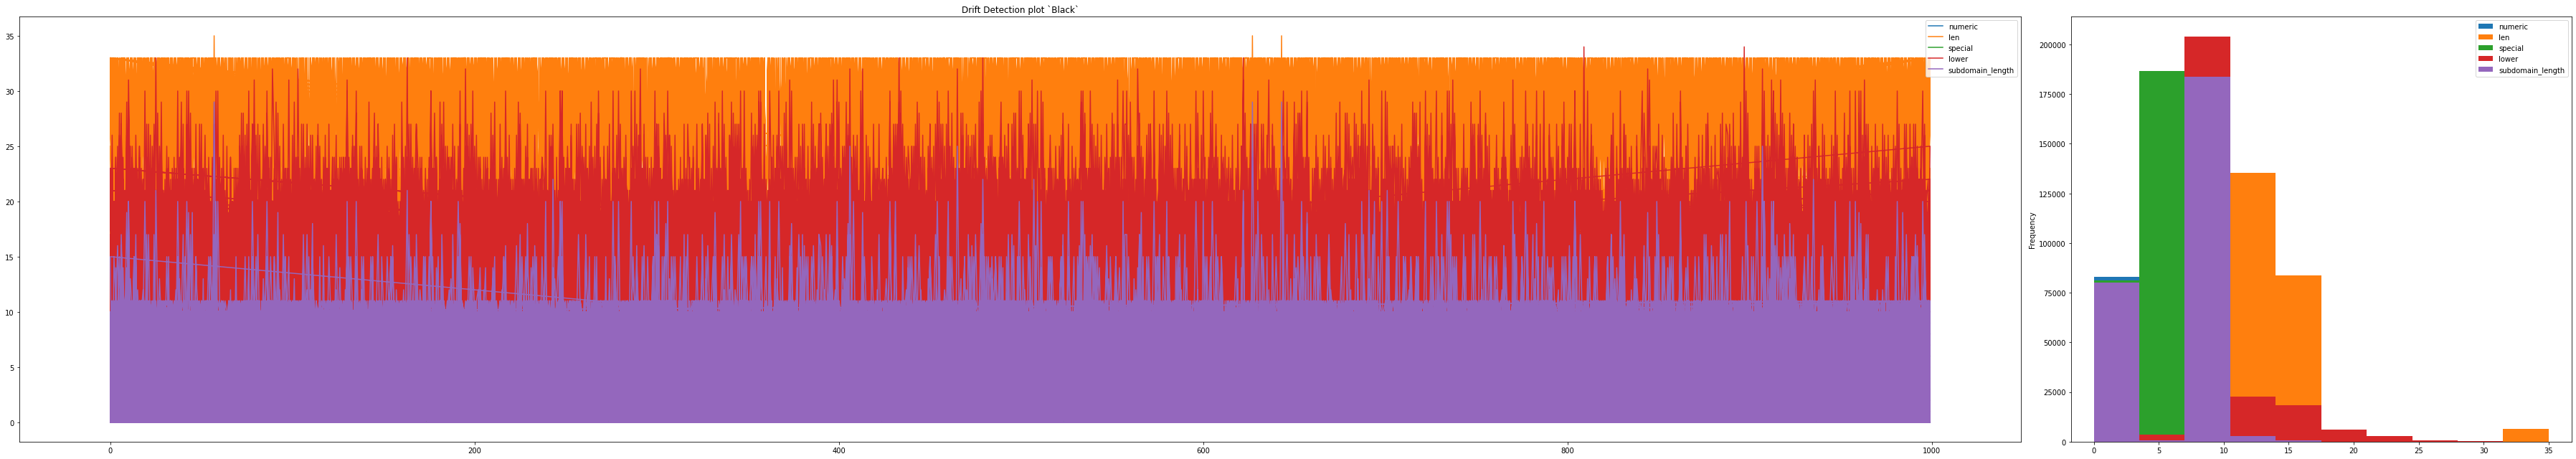

In [26]:
plot_data(X_stream)

### F1-score plot

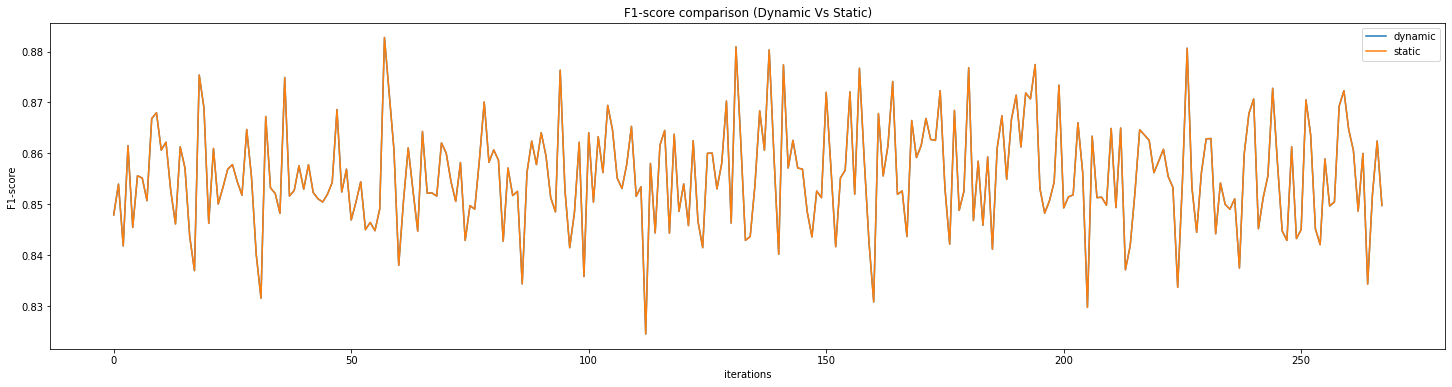

In [28]:
plt.figure(figsize = (25,6))
plt.plot(iterations, dynmaic_f1, label='dynamic')
plt.plot(iterations,static_f1, label='static')
plt.xlabel('iterations')
plt.ylabel("F1-score")
plt.legend()
plt.title("F1-score comparison (Dynamic Vs Static)")
plt.show()

In [38]:
np.array(static_f1).mean()

0.8557170433903344

## Performance Degradation – Forgetting learner (268074):
When the dynamic model F1-score decreases for 2 iterations respectively. It has drawbacks when the decrease is much larger than the increase, moreover, if the F1-score increases then decrease every consecutive iteration, the model will never retrain (worst-case scenario). The training window is equal to the length of the static data (268074) as the static model was trained. 

training window = len(static_df) = 268074

In [101]:
consumer = resetConsumer()
dynamic_pipe = deepcopy(static_pipe)

dynmaic_f1 = []
static_f1=[]
drifts =[]
training_time =[]
retrain_itr = []
X_stream = pd.DataFrame()
y_stream = pd.DataFrame()

# 268065/1000 = 268
iterations = range(268)

for itr in iterations:
    print(f"window number {itr} ------------------------------------------")
    window = getWindow()
    window_df =  window_to_df(window) #convert window to dataframe

    X = window_df[selected_featues]   # use the selected features from the static model feature selection process
    y = window_df["Target Attack"]

    X_stream = pd.concat([X_stream, X],axis=0) # add the current window to the global streaming data
    y_stream = pd.concat([y_stream, y],axis=0)
    pred_d = dynamic_pipe.predict(X)  
    d_f1 = f1_score(y, pred_d)
    if len(dynmaic_f1)>=2 and d_f1<dynmaic_f1[-1] and dynmaic_f1[-1] <dynmaic_f1[-2]:  # Performance degradation at the last 2 iterations
        print("Performance degradation -> retrain")
        start = time()
        forgetting_learner(X_stream,y_stream, train_window = len(static_df))
        end = time()
        t = end-start
        print(f"training time = {t}")
        pred_d = dynamic_pipe.predict(X)  
        d_f1 = f1_score(y, pred_d)
        training_time.append(t)
        retrain_itr.append(itr)


    
    print("Dynamic F1score: ",d_f1)
    pred_s= static_pipe.predict(X)
    s_f1=f1_score(y, pred_s)
    print("Static F1-score: ",s_f1)

    dynmaic_f1.append(d_f1)
    static_f1.append(s_f1)


window number 0 ------------------------------------------
Dynamic F1score:  0.8479485116653259
Static F1-score:  0.8479485116653259
window number 1 ------------------------------------------
Dynamic F1score:  0.8539857932123127
Static F1-score:  0.8539857932123127
window number 2 ------------------------------------------
Dynamic F1score:  0.8418604651162791
Static F1-score:  0.8418604651162791
window number 3 ------------------------------------------
Dynamic F1score:  0.8615149196633513
Static F1-score:  0.8615149196633513
window number 4 ------------------------------------------
Dynamic F1score:  0.8454763811048838
Static F1-score:  0.8454763811048838
window number 5 ------------------------------------------
Dynamic F1score:  0.8556231003039514
Static F1-score:  0.8556231003039514
window number 6 ------------------------------------------
Dynamic F1score:  0.8551724137931034
Static F1-score:  0.8551724137931034
window number 7 ------------------------------------------
Performanc

### F1-score plot

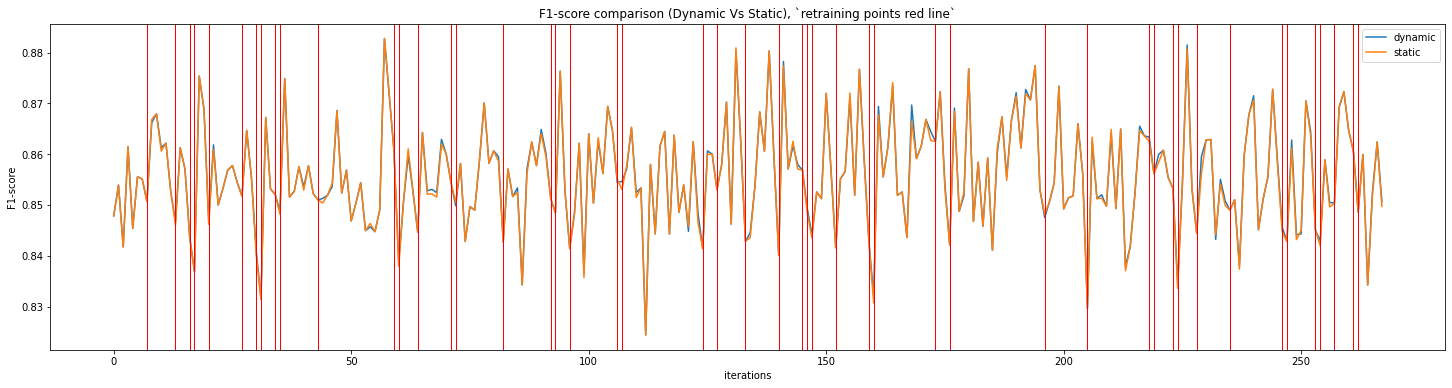

In [102]:
plt.figure(figsize = (25,6))
plt.plot(iterations[:len(dynmaic_f1)], dynmaic_f1, label='dynamic')
plt.plot(iterations[:len(dynmaic_f1)],static_f1, label='static')
[plt.axvline(_x, linewidth=1, color='r') for _x in retrain_itr]
plt.xlabel('iterations')
plt.ylabel("F1-score")
plt.legend()
plt.title("F1-score comparison (Dynamic Vs Static), `retraining points red line`")
plt.show()

total training time =  1376.2365140914917
Number of retraining =  49


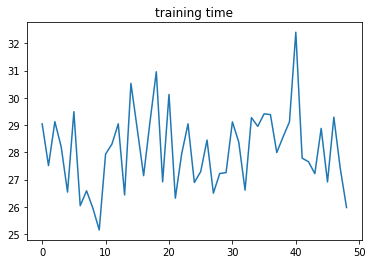

In [103]:
print("total training time = ",sum(training_time))
print("Number of retraining = ",len(training_time))

plt.plot(training_time)
plt.title("training time")
plt.show()

In [104]:
print("dynmaic_f1 mean: ",np.array(dynmaic_f1).mean())
print("static_f1 mean: " ,np.array(static_f1).mean())

dynmaic_f1 mean:  0.8558752739336878
static_f1 mean:  0.8557170433903344


## Performance Degradation – Forgetting learner (50000): 
same as before, but with less training window = 50000

In [108]:
consumer = resetConsumer()
dynamic_pipe = deepcopy(static_pipe)
train_window = 50000
dynmaic_f1 = []
static_f1=[]
drifts =[]
training_time =[]
retrain_itr = []
X_stream = pd.DataFrame()
y_stream = pd.DataFrame()

# 268065/1000 = 268
iterations = range(268)

for itr in iterations:
    print(f"window number {itr} ------------------------------------------")
    window = getWindow()
    window_df =  window_to_df(window) #convert window to dataframe

    X = window_df[selected_featues]   # use the selected features from the static model feature selection process
    y = window_df["Target Attack"]

    X_stream = pd.concat([X_stream, X],axis=0) # add the current window to the global streaming data
    y_stream = pd.concat([y_stream, y],axis=0)
    pred_d = dynamic_pipe.predict(X)  
    d_f1 = f1_score(y, pred_d)
    if len(dynmaic_f1)>=2 and d_f1<dynmaic_f1[-1] and dynmaic_f1[-1] <dynmaic_f1[-2]:  # Performance degradation at the last 2 iterations
        print("Performance degradation -> retrain")
        start = time()
        forgetting_learner(X_stream,y_stream, train_window = train_window)
        end = time()
        t = end-start
        print(f"training time = {t}")
        pred_d = dynamic_pipe.predict(X)  
        d_f1 = f1_score(y, pred_d)
        training_time.append(t)
        retrain_itr.append(itr)

    print("Dynamic F1score: ",d_f1)
    pred_s = static_pipe.predict(X)
    s_f1 = f1_score(y, pred_s)
    print("Static F1-score: ",s_f1)

    dynmaic_f1.append(d_f1)
    static_f1.append(s_f1)

window number 0 ------------------------------------------
Dynamic F1score:  0.8479485116653259
Static F1-score:  0.8479485116653259
window number 1 ------------------------------------------
Dynamic F1score:  0.8539857932123127
Static F1-score:  0.8539857932123127
window number 2 ------------------------------------------
Dynamic F1score:  0.8418604651162791
Static F1-score:  0.8418604651162791
window number 3 ------------------------------------------
Dynamic F1score:  0.8615149196633513
Static F1-score:  0.8615149196633513
window number 4 ------------------------------------------
Dynamic F1score:  0.8454763811048838
Static F1-score:  0.8454763811048838
window number 5 ------------------------------------------
Dynamic F1score:  0.8556231003039514
Static F1-score:  0.8556231003039514
window number 6 ------------------------------------------
Dynamic F1score:  0.8551724137931034
Static F1-score:  0.8551724137931034
window number 7 ------------------------------------------
Performanc

### F1-score plot

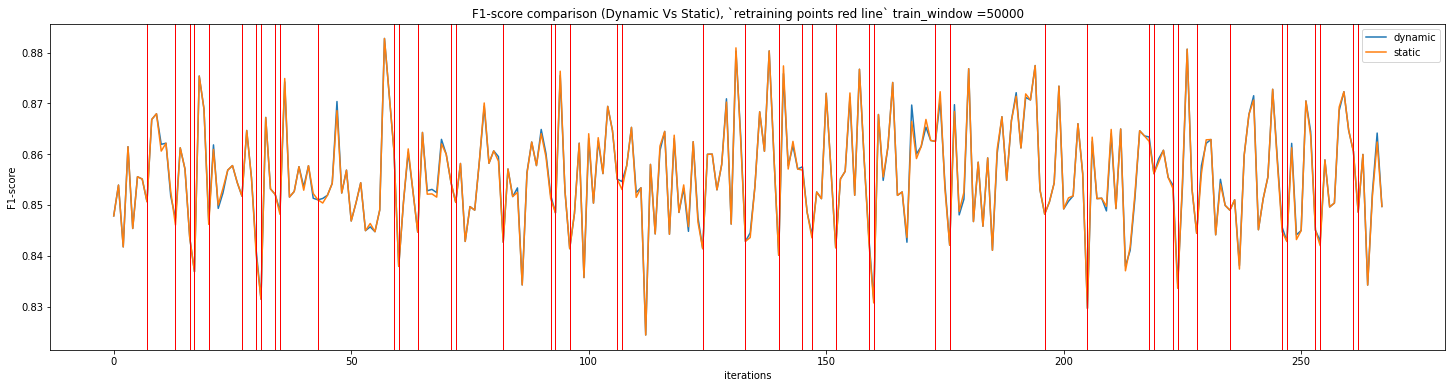

In [109]:
plt.figure(figsize = (25,6))
plt.plot(iterations[:len(dynmaic_f1)], dynmaic_f1, label='dynamic')
plt.plot(iterations[:len(dynmaic_f1)],static_f1, label='static')
[plt.axvline(_x, linewidth=1, color='r') for _x in retrain_itr]
plt.xlabel('iterations')
plt.ylabel("F1-score")
plt.legend()
plt.title(f"F1-score comparison (Dynamic Vs Static), `retraining points red line` train_window ={train_window}")
plt.show()

total training time =  511.33461451530457
Number of retraining =  46


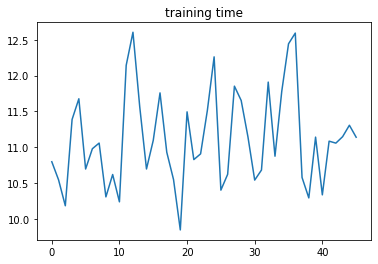

In [110]:
print("total training time = ",sum(training_time))
print("Number of retraining = ",len(training_time))

plt.plot(training_time)
plt.title("training time")
plt.show()

In [111]:
print("dynmaic_f1 mean: " ,np.array(dynmaic_f1).mean())
print("static_f1 mean: " ,np.array(static_f1).mean())

dynmaic_f1 mean:  0.855781449676285
static_f1 mean:  0.8557170433903344


## Performance Degradation – Remember learner (268074):

In [112]:
consumer = resetConsumer()
dynamic_pipe = deepcopy(static_pipe)
train_window = len(static_df)
dynmaic_f1 = []
static_f1=[]
drifts =[]
training_time =[]
retrain_itr = []
X_stream = pd.DataFrame()
y_stream = pd.DataFrame()

# 268065/1000 = 268
iterations = range(268)

for itr in iterations:
    print(f"window number {itr} ------------------------------------------")
    window = getWindow()
    window_df =  window_to_df(window) #convert window to dataframe

    X = window_df[selected_featues]   # use the selected features from the static model feature selection process
    y = window_df["Target Attack"]

    X_stream = pd.concat([X_stream, X],axis=0) # add the current window to the global streaming data
    y_stream = pd.concat([y_stream, y],axis=0)
    pred_d = dynamic_pipe.predict(X)  
    d_f1 = f1_score(y, pred_d)
    if len(dynmaic_f1)>=2 and d_f1<dynmaic_f1[-1] and dynmaic_f1[-1] <dynmaic_f1[-2]:  # Performance degradation at the last 2 iterations
        print("Performance degradation -> retrain")
        start = time()
        remember_learner(X_stream,y_stream, train_window = train_window)
        end = time()
        t = end-start
        print(f"training time = {t}")
        pred_d = dynamic_pipe.predict(X)  
        d_f1 = f1_score(y, pred_d)
        training_time.append(t)
        retrain_itr.append(itr)
    
    print("Dynamic F1score: ",d_f1)
    pred_s= static_pipe.predict(X)
    s_f1=f1_score(y, pred_s)
    print("Static F1-score: ",s_f1)
    
    dynmaic_f1.append(d_f1)
    static_f1.append(s_f1)


window number 0 ------------------------------------------
Dynamic F1score:  0.8479485116653259
Static F1-score:  0.8479485116653259
window number 1 ------------------------------------------
Dynamic F1score:  0.8539857932123127
Static F1-score:  0.8539857932123127
window number 2 ------------------------------------------
Dynamic F1score:  0.8418604651162791
Static F1-score:  0.8418604651162791
window number 3 ------------------------------------------
Dynamic F1score:  0.8615149196633513
Static F1-score:  0.8615149196633513
window number 4 ------------------------------------------
Dynamic F1score:  0.8454763811048838
Static F1-score:  0.8454763811048838
window number 5 ------------------------------------------
Dynamic F1score:  0.8556231003039514
Static F1-score:  0.8556231003039514
window number 6 ------------------------------------------
Dynamic F1score:  0.8551724137931034
Static F1-score:  0.8551724137931034
window number 7 ------------------------------------------
Performanc

### F1-score plot

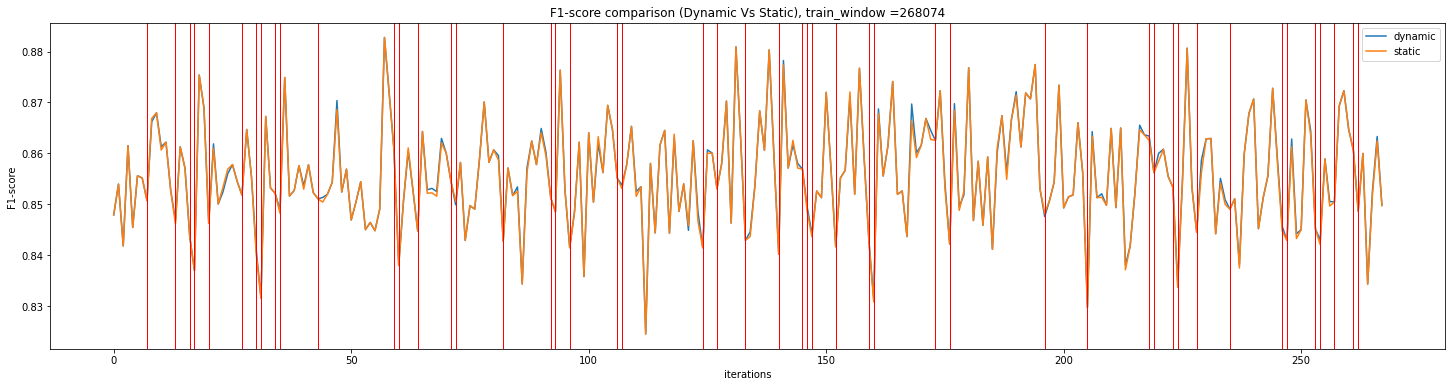

In [113]:
plt.figure(figsize = (25,6))
plt.plot(iterations, dynmaic_f1, label='dynamic')
plt.plot(iterations,static_f1, label='static')
[plt.axvline(_x, linewidth=1, color='r') for _x in retrain_itr]
plt.xlabel('iterations')
plt.ylabel("F1-score")
plt.legend()
plt.title(f"F1-score comparison (Dynamic Vs Static), train_window ={len(static_df)}")
plt.show()


total training time =  1382.8526377677917
Number of retraining =  49


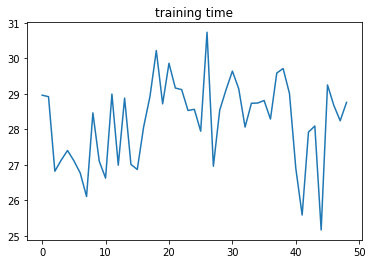

In [114]:
print("total training time = ",sum(training_time))
print("Number of retraining = ",len(training_time))

plt.plot(training_time)
plt.title("training time")
plt.show()

In [115]:
print("dynmaic_f1 mean: " ,np.array(dynmaic_f1).mean())
print("static_f1 mean: " ,np.array(static_f1).mean())

dynmaic_f1 mean:  0.8558833611565444
static_f1 mean:  0.8557170433903344


## F1-score threshold 0.84 with training window = 268074
re-train when Dynamic f1-score gets lower than 0.84. using Remember Leanrner


In [116]:
consumer = resetConsumer()
dynamic_pipe = deepcopy(static_pipe)
train_window = len(static_df)
threshold = .84
dynmaic_f1 = []
static_f1=[]
drifts =[]
training_time =[]
retrain_itr = []
X_stream = pd.DataFrame()
y_stream = pd.DataFrame()

# 268065/1000 = 268
iterations = range(268)

for itr in iterations:
    print(f"window number {itr} ------------------------------------------")
    window = getWindow()
    window_df =  window_to_df(window) #convert window to dataframe

    X = window_df[selected_featues]   # use the selected features from the static model feature selection process
    y = window_df["Target Attack"]

    X_stream = pd.concat([X_stream, X],axis=0) # add the current window to the global streaming data
    y_stream = pd.concat([y_stream, y],axis=0)
    pred_d = dynamic_pipe.predict(X)  
    d_f1 = f1_score(y, pred_d)
    if d_f1 < threshold:  
        print("Dynamic F1score less than threshold -> retrain")
        start = time()
        remember_learner(X_stream,y_stream, train_window = train_window)
        end = time()
        t = end-start
        print(f"training time = {t}")
        pred_d = dynamic_pipe.predict(X)  
        d_f1 = f1_score(y, pred_d)
        training_time.append(t)
        retrain_itr.append(itr)
    
    print("Dynamic F1score: ",d_f1)
    pred_s= static_pipe.predict(X)
    s_f1=f1_score(y, pred_s)
    print("Static F1-score: ",s_f1)
    
    dynmaic_f1.append(d_f1)
    static_f1.append(s_f1)


window number 0 ------------------------------------------
Dynamic F1score:  0.8479485116653259
Static F1-score:  0.8479485116653259
window number 1 ------------------------------------------
Dynamic F1score:  0.8539857932123127
Static F1-score:  0.8539857932123127
window number 2 ------------------------------------------
Dynamic F1score:  0.8418604651162791
Static F1-score:  0.8418604651162791
window number 3 ------------------------------------------
Dynamic F1score:  0.8615149196633513
Static F1-score:  0.8615149196633513
window number 4 ------------------------------------------
Dynamic F1score:  0.8454763811048838
Static F1-score:  0.8454763811048838
window number 5 ------------------------------------------
Dynamic F1score:  0.8556231003039514
Static F1-score:  0.8556231003039514
window number 6 ------------------------------------------
Dynamic F1score:  0.8551724137931034
Static F1-score:  0.8551724137931034
window number 7 ------------------------------------------
Dynamic F1

### F1-score plot

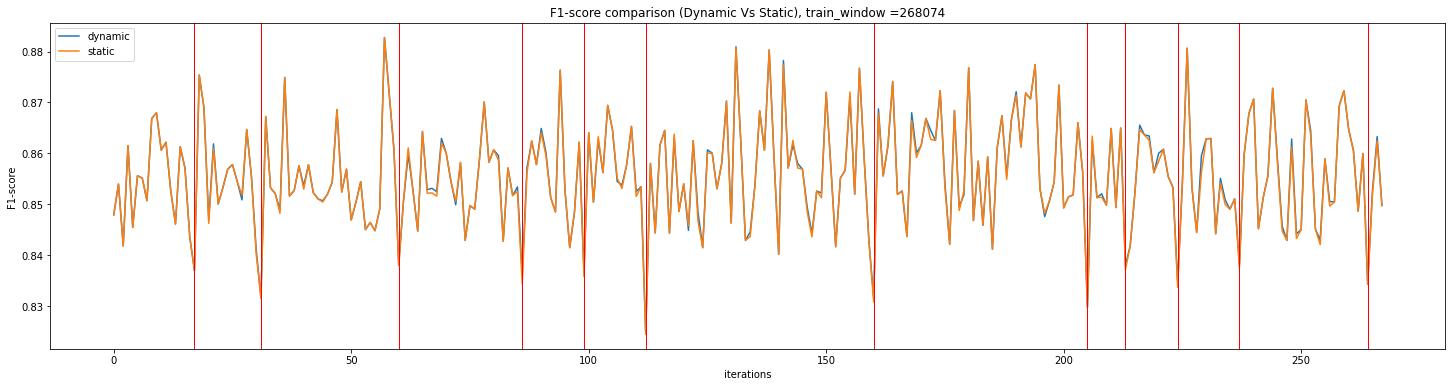

In [117]:
plt.figure(figsize = (25,6))
plt.plot(iterations, dynmaic_f1, label='dynamic')
plt.plot(iterations,static_f1, label='static')
[plt.axvline(_x, linewidth=1, color='r') for _x in retrain_itr]
plt.xlabel('iterations')
plt.ylabel("F1-score")
plt.legend()
plt.title(f"F1-score comparison (Dynamic Vs Static), train_window ={train_window}")
plt.show()


total training time =  339.8644003868103
Number of retraining =  12


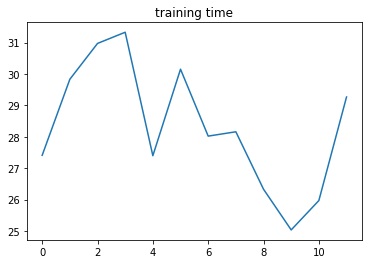

In [118]:
print("total training time = ",sum(training_time))
print("Number of retraining = ",len(training_time))

plt.plot(training_time)
plt.title("training time")
plt.show()

In [119]:
print("dynmaic_f1 mean: " ,np.array(dynmaic_f1).mean())
print("static_f1 mean: " ,np.array(static_f1).mean())

dynmaic_f1 mean:  0.855874727319266
static_f1 mean:  0.8557170433903344


# Result Analysis

In [ ]:
from numbers import Integral,Real
import random
from river import drift

rng = random.Random(12345)
adwin = drift.ADWIN()

data_stream = rng.choices([0, 1], k=1000) + rng.choices(range(4, 8), k=1000)
for i, val in enumerate(static_df[selected_featues].values):
    _ = kswin.update(Integral(val))
    if kswin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")


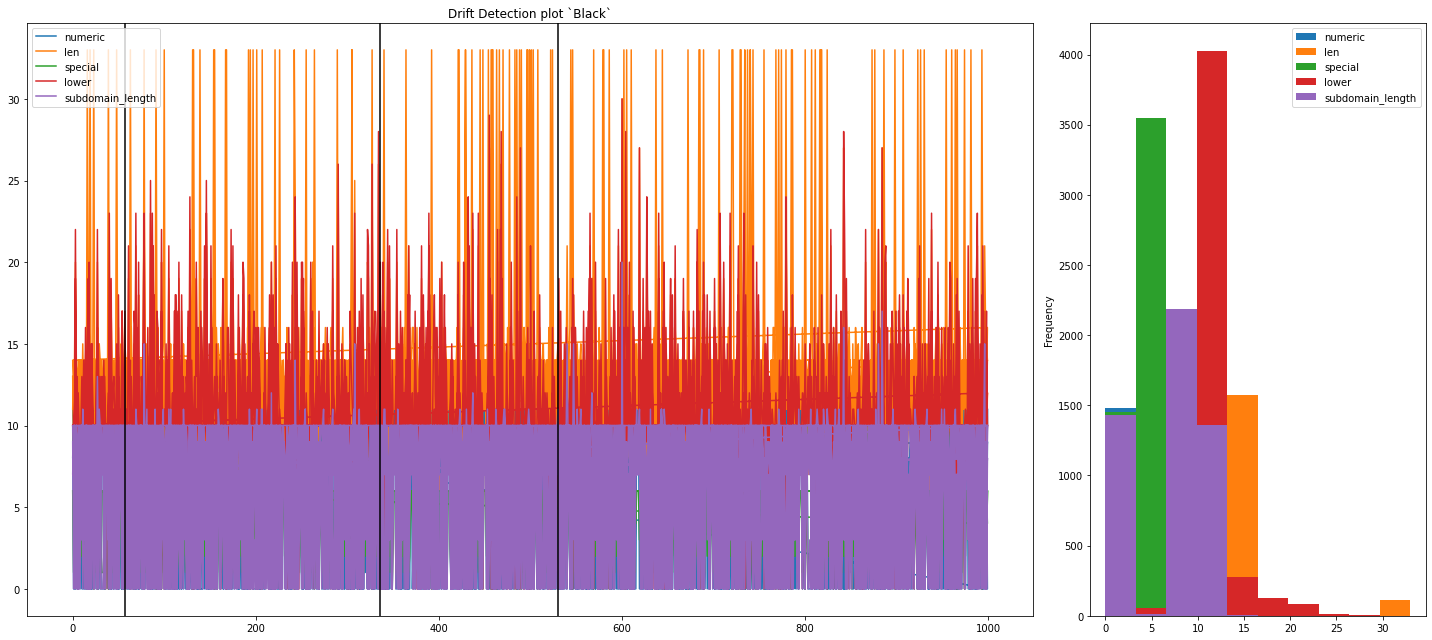

In [ ]:
# print(window_df.values)
# scaller = StandardScaler()
plot_data(X_stream,drifts=drifts)


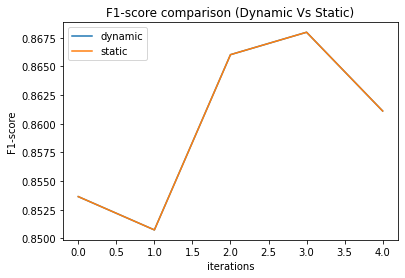

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iterations, dynmaic_f1, label='dynamic')
plt.plot(iterations,static_f1, label='static')
plt.xlabel('iterations')
#plt.xticks(range(1, 251))
plt.ylabel("F1-score")
plt.legend()
plt.title("F1-score comparison (Dynamic Vs Static)")
plt.show()

In [ ]:
max(dynmaic_f1)

0.8615149196633513